In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import median
from coordinate_converter import utm_to_ssb_grid_id

print("loading data")
df = pd.read_csv("proprietary_data/incidents_processed_2.csv", encoding='utf-8', escapechar='\\', parse_dates=True, low_memory=False)
urgencies = [["A"], ["H"], ["V", "V1", "V2"]]

loading data


calculating delay
filter and sort:


100%|██████████| 3/3 [00:00<00:00, 12.03it/s]


[88.0, 122.0, 209.0]


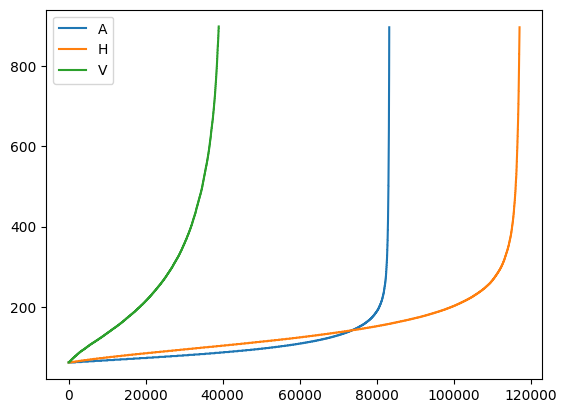

In [2]:
print("calculating delay")
df["delay"] = pd.to_datetime(df["rykker_ut"]) - pd.to_datetime(df["varslet"])

stop_point = -1
time_max = 60*15
time_min = 60

medians = []

print("filter and sort:")
for urgency in tqdm(urgencies):
    df_urgency = df[df["hastegrad"].isin(urgency)]
    df_urgency = pd.TimedeltaIndex(data = df_urgency["delay"])
    df_urgency = df_urgency.seconds.values
    df_urgency = [u for u in df_urgency if time_min < u < time_max]
    df_urgency.sort()
    df_urgency = df_urgency[:stop_point]
    medians.append(median(df_urgency))
    plt.plot(range(len(df_urgency)), df_urgency, label=urgency[0])

print(medians)

plt.legend()
plt.show()

calculating delay
filter and sort:


100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


[125.0, 365.0, 2186.0]


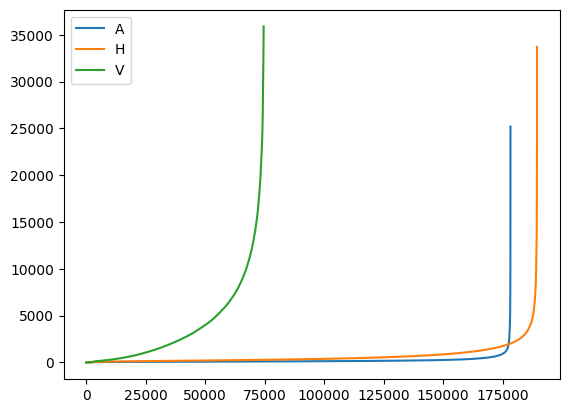

In [3]:
print("calculating delay")
df["handling"] = pd.to_datetime(df["varslet"]) - pd.to_datetime(df["tidspunkt"])

stop_point = -1
time_max = 60*600 
time_min = 0

medians_2 =[]

print("filter and sort:")
for urgency in tqdm(urgencies):
    df_urgency = df[df["hastegrad"].isin(urgency)]
    df_urgency = pd.TimedeltaIndex(data = df_urgency["handling"])
    df_urgency = df_urgency.seconds.values
    df_urgency = [u for u in df_urgency if time_min < u < time_max]
    df_urgency.sort()
    df_urgency = df_urgency[:stop_point]
    medians_2.append(median(df_urgency))
    plt.plot(range(len(df_urgency)), df_urgency, label=urgency[0])

print(medians_2)

plt.legend()
plt.show()

In [4]:
od_paths = {}
with open(f'data/od_paths.json', 'r') as r:
    od_paths = json.load(r)

In [5]:
def hospital_utm_to_grid_id(easting, northing):
    return f"_{easting:.0f}_{northing:.0f}"

def get_path(origin, destination):
    try:
        o = str(origin)
        d = str(destination)
        path = od_paths[o][d]
        return path["travel_time"]
    except:
        return -1

In [6]:
print("calculating delay")
df["timeToAvailable"] = pd.to_datetime(df["ledig_transport"]) - pd.to_datetime(df["avg_hentested"])
df["gridId"] = df.apply(lambda row: utm_to_ssb_grid_id(row["xcoor"], row["ycoor"]), axis=1)
hospitals = pd.read_csv("data/hospitals.csv")
hospitals["gridId"] = hospitals.apply(lambda row: hospital_utm_to_grid_id(row["xcoor"], row["ycoor"]), axis=1)
df["timeToHospital"] = df.apply(lambda row: min([get_path(row["gridId"], hospital_grid_id) for hospital_grid_id in hospitals["gridId"]]), axis=1)
df["hospitalTime"] = df["timeToAvailable"].dt.total_seconds() - df["timeToHospital"]

calculating delay


filter and sort:


100%|██████████| 3/3 [00:34<00:00, 11.58s/it]


[1381.0, 1283.0, 1448.0]


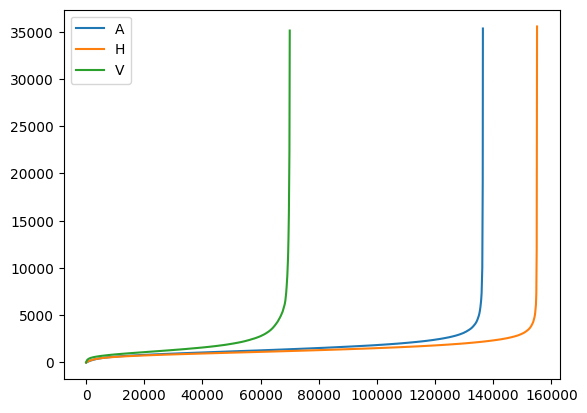

In [12]:
import numpy as np
stop_point = -1
time_max = 60*600 
time_min = 0

medians_3 = []

print("filter and sort:")
for urgency in tqdm(urgencies):
    df_urgency = df[df["hastegrad"].isin(urgency)]
    df_urgency = df_urgency["hospitalTime"]
    df_urgency = [u for u in df_urgency if not np.isnan(u) and time_min < u < time_max]
    df_urgency.sort()
    df_urgency = df_urgency[:stop_point]
    medians_3.append(median(df_urgency))
    plt.plot(range(len(df_urgency)), df_urgency, label=urgency[0])

print(medians_3)

plt.legend()
plt.show()